## Code for HW2, Problem 3

Here, we use a slightly modified version of the code in `./Module_2.ipynb` to calculate the efficient frontier curve. To parametrize the curve, we construct a portfolio out of 5 stocks, and calculate the optimal weights for each value of standard deviation of the portfolio. So our constrained optimization problem becomes the following:

Maximize $\mathcal{L} = \sum_i w_i E[r_i]$, subject to $\sum_i w_i = 1$ and $\sum_{ij} w_iw_j\sigma_{ij} = \sigma_p$, where $\sigma_p$ is pre-provided. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

%matplotlib inline

In [2]:
df = pd.read_csv("../data/2_Stock_Prices.csv", index_col=0, parse_dates=True)
# Clean/transform the data
df = df.dropna(axis=1)
df = df.apply(np.log)
# Get the dataframe with daily returns
returns_df = df.diff().dropna(axis=0)

In [114]:
from scipy.optimize import minimize

# Compute the return of the portfolio, the volatility, and the Sharpe Ratio
def get_ret_vol_sr(weights, means, cov, rf=0.05):
    weights = np.array(weights)
    # The means you enter are daily expected returns, so annualize them.
    ret = np.sum(means*weights*252)
    # The volatility is w*Sigma*w
    vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))

    sr = (ret-rf)/vol

    return np.array([ret, vol, sr])

def find_weights(means, cov, std, rf=0.05):
    '''For a fixed value of portfolio standard deviation, std, 
       find the optimal set of weights that maximizes the expected return.'''
    
    # Compute the return of the portfolio, the volatility, and the Sharpe Ratio
    def get_ret_vol_sr(weights):
        weights = np.array(weights)
        # The means you enter are daily expected returns, so annualize them.
        ret = np.sum(means*weights*252)
        # The volatility is w*Sigma*w
        vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))

        sr = (ret-rf)/vol

        return np.array([ret, vol, sr])    
          
    # We want to maximize the Sharpe Ratio, ergo minimize the negative Sharpe Ratio.
    def neg_sharpe(weights):
        return -get_ret_vol_sr(weights)[2]

    # Function for the constraints: We want to invest all of our money, nothing more, nothing less.
    def check_sum(weights):
        # Return 0 if sum of the weights is 1
        return np.sum(weights)-1
    
    def fix_vol(weights, std):
        '''Constraint on the portfolio uncertainty.'''
        return get_ret_vol_sr(weights)[1] - std
    
    # Set the constraint: Weights need to sum to 1.
    cons = ({"type":"eq", "fun":check_sum}, {"type":"eq", "fun":fix_vol, "args":[std]})
    # Each stock should have some weight between 0 and 100% in our portfolio.
    bounds = tuple([(0,1) for _ in range(len(means))])
    
    # Our initial guess is equally spreading the money.
    init_guess = [1./len(means) for _ in range(len(means))]
    
    # Optimize!
    opt_results = minimize(neg_sharpe, init_guess, method="SLSQP", bounds=bounds, constraints=cons)
    
    return opt_results

In [142]:
# Choose 5 stocks
my_df = returns_df.loc[:, ['AAPL', 'JPM', 'EBAY', 'NFLX', 'ORCL']]
# Expected return of each individual stock
means = np.array([0.065/252, 0.07/252, 0.08/252, 0.075/252, 0.06/252])
# Covariance estimated from S&P 500 data
cov = my_df.cov()

#std=np.linspace(0.001,0.015)
std = np.arange(10,15,0.25)*0.001
# For each standard deviation (combined)
# run the optimizer to find the optimal weights
# and using the optimal weights, get the exp. return
returns = np.zeros_like(std)
vols = np.zeros_like(std)
sharpe_ratios = np.zeros_like(std)
weight_list = []
for idx, dev in enumerate(std):
    # Run the optimizer
    opt = find_weights(means, cov, dev, rf=0.02)
    # If you output opt, you get a bunch of info, and in "x", the weights are stored.
    weights = opt["x"]
    weight_list.append(weights)
    # Get the expected return out of the portfolio
    # using the optimal weights
    ret, vol, sr = get_ret_vol_sr(weights, means, cov)
    returns[idx] = ret
    print(vol)
    vols[idx] = vol
    sharpe_ratios[idx] = sr

0.010210438748849854
0.010250000075942255
0.010500000886611743
0.010750004377309464
0.011000000509737875
0.011250000401458925
0.011500000253805688
0.011750000501260746
0.012000001372065567
0.012250000197041661
0.012500000976630975
0.012750000296076813
0.0130000002766025
0.013250000039177165
0.013500001604646563
0.013750002036902296
0.014000000473353109
0.014250000338450529
0.014500000798177147
0.014750000049335061


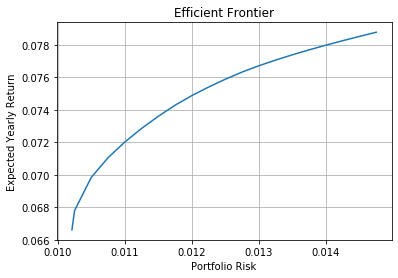

In [143]:
# Plot the efficient frontier curve!
fig, ax = plt.subplots(1,1)
ax.plot(vols, returns)
ax.set_xlabel('Portfolio Risk')
ax.set_ylabel('Expected Yearly Return')
ax.set_title('Efficient Frontier')
ax.grid(True)
fig.savefig('./output/eff_frontier.pdf')

### Find Maximum Sharpe Ratio

Here, we plot the Sharpe Ratios for each possible combination of stocks lying in Efficient Frontier curve, and find the optimal portfolio that maximizes the Sharpe Ratio.  

Maximum return: 0.0754


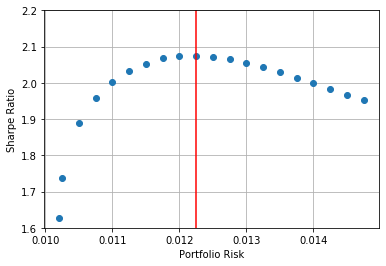

In [144]:
# Find the maximum SR
idx_max = np.argmax(sharpe_ratios)
vol_max = vols[idx_max]
ret_max = returns[idx_max]
print(f'Maximum return: {ret_max:.4f}')

fig, ax = plt.subplots(1,1)
ax.plot(vols, sharpe_ratios, 'o')
ax.plot([vol_max]*2, [1.6,2.2], 'r')
ax.set_ylim(1.6, 2.2)
ax.set_xlabel('Portfolio Risk')
ax.set_ylabel('Sharpe Ratio')
ax.grid(True)
fig.savefig('./output/sr_risk_rf_002.pdf')

In [138]:
print(sharpe_ratios)
vols[np.argmax(sharpe_ratios)]

[1.62614296 1.7360727  1.89007573 1.95869734 2.00196577 2.03173503
 2.0529503  2.06732607 2.07345549 2.07416969 2.07133687 2.06527017
 2.05536597 2.04307434 2.0292784  2.01451597 1.99913822 1.9833853
 1.96742693 1.95138597]


0.012250000038908209

In [139]:
print(sharpe_ratios)
vols[np.argmax(sharpe_ratios)]

[1.62614296 1.7360727  1.89007573 1.95869734 2.00196577 2.03173503
 2.0529503  2.06732607 2.07345549 2.07416969 2.07133687 2.06527017
 2.05536597 2.04307434 2.0292784  2.01451597 1.99913822 1.9833853
 1.96742693 1.95138597]


0.012250000038908209

In [140]:
weight_list[idx_max] # rf = 0.0

array([0.03777829, 0.36230265, 0.51957498, 0.08034408, 0.        ])

In [145]:
weight_list[idx_max] # rf = 0.02

array([3.77660560e-02, 3.62320355e-01, 5.19568286e-01, 8.03453031e-02,
       1.71337825e-17])

In [ ]:
weight_list[idx_max] # rf = 0.05